## モデル構築

In [6]:
#データの収集

%matplotlib inline
import numpy as np
import torch

import matplotlib.pyplot as plt

In [7]:
#t_cは摂氏
#t_uは単位が知りたい値
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

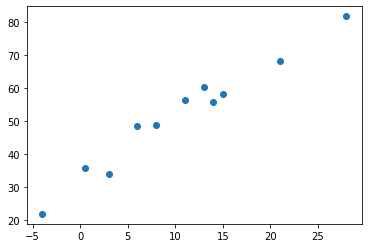

In [9]:
plt.scatter(t_c, t_u)

In [11]:
#データを収集したら、可視化、線形モデルをためす。
#線形モデル　t_c = w * t_u + b
#予測値と測定値の誤差が小さくなるようにモデルのパラメータ（ｗ：重みとｂ：バイアス）を推定する
#誤差の測定方法に損失関数を用いる
#この損失関数が最小になるようなw,bを見つけることを目標とする

## パラメータの推定と損失関数

In [13]:
#モデル作成
def model (t_u, w, b):
    return w* t_u + b

In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [19]:
#パラメータの初期化
w = torch.ones(())
b = torch.zeros(())

In [20]:
w

tensor(1.)

In [16]:
t_p = model(t_u ,w ,b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [21]:
#この段階で損失
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [ ]:
#損失を小さくするためには